#### This is a Databricks Notebook for POC Modelling Experimentation with AutoML
In the inital phase of developing a ML solution, there is a need for experimentation before determining the best approach to develop the ML solution. This Notebook provides a framework to help with trying out modelling of different modelling ideas/methods with the help of AutoML. In this notebook, we leverage on AutoML's algorithm to try different ML models and pick the best method, while using the compute resource of Databricks. The data set is based on price demand for power. This example implementation holds additional information on dependency issues, datalake as source and visualization of results.  <br>

**Input(s)**: Consolidated dataset with standardized features using data preparation steps.  
**Outputs(s)**: Performance of the modelling idea/method on the test set <br>
**Recommended Cluster** : DBS_MAIN_SPARK3.0 (in order to run AutoML, we need to install the AzureML-SDK) <br>
**Note**: This template is created based on this <a href="https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/azure-databricks/automl/automl-databricks-local-01.ipynb" title="AutoML With Databricks">Notebook</a>, users can refer to this for more information. 

#### Step 1: Setting up of Azure Machine Learning Environment
For Databricks non ML runtime 7.1(scala 2.21, spark 3.0.0) and up, Install AML sdk by running the following command in the first cell of the notebook.

In [ ]:
%pip install --upgrade --force-reinstall -r https://aka.ms/automl_linux_requirements.txt

In [0]:
### Importing Azure related libraries
import azureml.core
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace, Dataset, Datastore
from azureml.core.experiment import Experiment
from azureml.core.authentication import ServicePrincipalAuthentication
print("This notebook was created using version 1.18.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

### Importing other requried libraries
import pandas as pd
import glob, logging
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit,  KFold

This notebook was created using version 1.18.0 of the Azure ML SDK
You are currently using version 1.18.0 of the Azure ML SDK

#### Step 2: Connecting to the exisiting Azure ML workspace.
- An Azure ML workspace is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, operationalization, and the monitoring of operationalized models.

 

In [ ]:
### Getting required passwords & secrets from Azure Key vault ###
akv_scope_secrets = ""

SUBSCRIPTION_ID = dbutils.secrets.get(scope = akv_scope_secrets, key = '')
RESOURCE_GROUP = '' 
WORKSPACE_NAME = ''  

TENANT_ID = dbutils.secrets.get(scope = akv_scope_secrets, key = '')
SERVICE_PRINCIPAL_ID = dbutils.secrets.get(scope = akv_scope_secrets, key = '')
SERVICE_PRINCIPAL_PASSWORD = dbutils.secrets.get(scope = akv_scope_secrets, key = '')

### Connecting to the Azure Workspace using the appropriate credentials ###
svc_pr = ServicePrincipalAuthentication(
     tenant_id = TENANT_ID,
     service_principal_id = SERVICE_PRINCIPAL_ID,
     service_principal_password = SERVICE_PRINCIPAL_PASSWORD)

ws = Workspace(workspace_name = WORKSPACE_NAME,
               subscription_id = SUBSCRIPTION_ID,
               resource_group = RESOURCE_GROUP,
               auth=svc_pr)

#### How do we persist the information of the workspace into the databricks
# ws.get_details()
# Persist the subscription id, resource group name, and workspace name in aml_config/config.json.
# ws.write_config()
# write_config(path="/databricks/driver/aml_config/",file_name=<alias_conf.cfg>)

print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

In [ ]:
# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-local-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

#### Step 3: Loading Data Using Dataset
In the POC_DataPrep notebook, the prepared dataset was written into the Experiment Path in the Datalake.
In order for Azure Auto ML to access the data, we need to register the data as a Dataset. This is the only way which Azure AutoML can access the data. This is done via a two step process:
1. Estabish Connection ot the Datalake to Azure Datastore (only need to run once)
2. Registering csv(s) or datafiles as a Dataset using the Azure DataSet Function. For more information on Azure DataSets, refer to the following <a href="https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.dataset_factory.tabulardatasetfactory?view=azure-ml-py#from-delimited-files-path--validate-true--include-path-false--infer-column-types-true--set-column-types-none--separator------header--promoteheadersbehavior-all-files-have-same-headers--3--" title="Azure Datastore Documentation">link</a>.

In [0]:
#### Establishing Connection from Datalake to Azure Datastore
## Only need to run once. 
from azureml.core import Dataset, Datastore

akv_scope_secrets=""
aad_tenant_id=""
aad_sp_client_id=""
aad_sp_client_secret=""

adl_g2_account_name="s"

adlsgen2_datastore_name = ''

adl_g2_account_name = "" # ADLS Gen2 account name

#The followinf details can be accessed using dbutils with secret scope access.

tenant_id = dbutils.secrets.get(scope = akv_scope_secrets, key = aad_tenant_id) # tenant id of service principal
client_id = dbutils.secrets.get(scope = akv_scope_secrets, key = aad_sp_client_id) # client id of service principal
client_secret = dbutils.secrets.get(scope = akv_scope_secrets, key = aad_sp_client_secret) # the secret of service principal

adlsgen2_datastore = Datastore.register_azure_data_lake_gen2(workspace=ws,
                                                     datastore_name=adlsgen2_datastore_name,
                                                     account_name=adl_g2_account_name, # ADLS Gen2 account name
                                                     filesystem='', # ADLS Gen2 filesystem
                                                     tenant_id=tenant_id, # tenant id of service principal
                                                     client_id=client_id, # client id of service principal
                                                     client_secret=client_secret) # the secret of service principal

In [ ]:
#### Identifying path of datasets in datalake and connecting to them ####
Data_path = '' ## Path where raw data is stored 
Experiment_path = ''

### Obtaining the path of the Training Data in the datalake
### data is stored in datalake in hierarchial fashion based on Functional and datetime partitions. 
dates = [datetime.strptime(fn.split('_')[-1], '%Y%m%d.csv') for fn in glob.glob(Experiment_path + 'training_data*.csv')]
TrainDataFile = [fn for fn in glob.glob(Experiment_path + 'training_data*.csv') if max(dates).strftime('%Y%m%d.csv') in fn][0]
print('Path of Data File in Databricks Mount:', TrainDataFile)
DataStore_TrainPath = TrainDataFile.replace('/dbfs/mnt/','') 
print('Path of Data File in DataStore :', DataStore_TrainPath)
DataStore_TestPath = DataStore_TrainPath.replace('training_data','testing_data') 

In [0]:
### Registering the Training Data as a Dataset
datastore = Datastore.get(ws, 'adlsgen2datastore')
datastore_paths = [(datastore, DataStore_TrainPath)]

TrainDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
allcols = TrainDF.to_pandas_dataframe().columns 
cv_cols = [col for col in allcols if 'cv' in col]
TrainDF = TrainDF.drop_columns(columns=['SETTLEMENTDATE','REGION','PERIODTYPE']+ cv_cols) ## Remove unwanted columns from Dataset

### Registering the Testing Data as a Dataset
datastore_paths = [(datastore, DataStore_TestPath)]

TestDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
TestDF = TestDF.drop_columns(columns=['SETTLEMENTDATE','REGION','PERIODTYPE']) ## Remove unwanted columns from Dataset
display(TestDF.take(5).to_pandas_dataframe()) ## Taking a look at the first 5 rows of data 

#### Example of getting data from an HTTP source
# example_data = 'https://dprepdata.blob.core.windows.net/demo/crime0-random.csv'
# dataset = Dataset.Tabular.from_delimited_files(example_data)

TOTALDEMAND,RRP,Month,Day,Day_of_week
7128.87,38.45,7,31,4
7460.04,38.77,7,31,4
7845.17,34.85,7,31,4
8548.16,40.34,7,31,4
9280.69,51.28,7,31,4


#### Step 4: Configure and Start AutoML
Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment. Below is a table of commonly used settings used with AutoML. For whole list of avaliable parameters/settings please refer to the <a href="https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py" title="AutoML Config Documentation">documentation</a>.
- In this notebook, we provide two examples of implementing cross validation. 
  1. Using AutoML's default cross-validation method
  2. Specifying our own custom cross-validation method (Suitable for time-series / advanced analystics which require some custom cross-validation method.)

|Property|Description|
|-|-|
|**task**|classification, regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**spark_context**|Spark Context object. For Databricks, use spark_context=sc. This replaces the `compute_target` needed when submitting to run the jobs on AzureML Workspace|
|**max_concurrent_iterations**|Maximum number of iterations to execute in parallel. This should be <= number of worker nodes in your Azure Databricks cluster.|
|**n_cross_validations**|Number of cross validation splits.|
|**cv_split_column_names**|Include custom CV split columns in your training data, and specify which columns by populating the column names in the cv_split_column_names parameter. Each column represents one cross-validation split, and is filled with integer values 1 or 0 --where 1 indicates the row should be used for training and 0 indicates the row should be used for validation.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**X_valid**| Validation features to use when fitting pipelines during an experiment. <br> If specified, then y_valid or sample_weight_valid must also be specified.|
|**y_valid**| Validation labels to use when fitting pipelines during an experiment.<br> Both X_valid and y_valid must be specified together.|
|**sample_weight_valid**| The weight to give to each validation sample when running scoring pipelines, each row should correspond to a row in X and y data. <br> Specify this parameter when specifying X_valid.|

Note: 
1. In some examples/references, `cv_splits_indices` is used to specify cross-validation folds. Note that it is only avaliable for AzureML Python SDK < ver. 1.6.0 and that it is used with X and y dataset input only)
2. For Azure Machine Learning Python SDK version 1.6.0 or later, please use `cv_split_column_names` with training_data and label_column_name.
3. More details on specifying cross-validation for Azure ML can be found <a href="https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-cross-validation-data-splits" title="AutoML Cross-Validation Documentation">here</a>

In [0]:
### Example 1: Allowing for AutoML to auto determine the cross validation ###
# automl_config = AutoMLConfig(task = 'regression',
#                              debug_log = 'automl_errors.log',
#                              primary_metric = 'normalized_root_mean_squared_error',
#                              iteration_timeout_minutes = 10,
#                              iterations = 5, #change it to increase the number of iterations
#                              n_cross_validations = 10,
#                              max_concurrent_iterations = 2, #change it based on number of worker nodes
#                              verbosity = logging.INFO,
#                              spark_context=sc, #databricks/spark related
#                              training_data=TrainDF,
#                              label_column_name='RRP')

In [0]:
### Example 2: To use the our own cross-validation method ###
## Reload the required datasets, do not drop the cross-validation columns this time.
datastore = Datastore.get(ws, 'adlsgen2datastore')
datastore_paths = [(datastore, DataStore_TrainPath)]

TrainDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
TrainDF = TrainDF.drop_columns(columns=['SETTLEMENTDATE','REGION','PERIODTYPE']) ## Remove unwanted columns from Dataset

datastore_paths = [(datastore, DataStore_TestPath)]

TestDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
TestDF = TestDF.drop_columns(columns=['SETTLEMENTDATE','REGION','PERIODTYPE']) ## Remove unwanted columns from Dataset

### Passing specific training dataset with cv_split_column_names to indicate cv folds ###
automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'normalized_root_mean_squared_error',
                             iteration_timeout_minutes = 10,
                             iterations = 20, #change it to increase the number of iterations
                             cv_split_column_names = cv_cols,
                             max_concurrent_iterations = 2, #change it based on number of worker nodes
                             verbosity = logging.INFO,
                             spark_context=sc, #databricks/spark related
                             training_data=TrainDF,
                             label_column_name='RRP'
                             )

In [0]:
cv_cols

Out[9]: ['cv1', 'cv2', 'cv3', 'cv4', 'cv5', 'cv6', 'cv7', 'cv8', 'cv9', 'cv10']

In [0]:
TrainDF.take(5).to_pandas_dataframe()

,TOTALDEMAND,RRP,Month,Day,Day_of_week,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
0,6591.84,43.30,12,1,6,1,1,1,1,1,1,1,1,1,1
1,6436.28,44.27,12,1,6,1,1,1,1,1,1,1,1,1,1
2,6190.87,42.56,12,1,6,1,1,1,1,1,1,1,1,1,1
3,6008.96,40.00,12,1,6,1,1,1,1,1,1,1,1,1,1
4,5911.00,54.86,12,1,6,1,1,1,1,1,1,1,1,1,1


In [0]:
### Submitting the AutoML experiment to Azure ML workspace to run.
local_run = experiment.submit(automl_config, show_output = True)
# RunDetails(automl_run).show()
# automl_run.wait_for_completion(show_output=True)

Running on ADB.
Running an experiment on spark cluster: automl-local-regression.

Parent Run ID: AutoML_a02a33ba-5394-4914-b5b3-677dd5130aa7


****************************************************************************************************
DATA GUARDRAILS: 

TYPE: Missing feature values imputation
STATUS: PASSED
DESCRIPTION: No feature missing values were detected in the training data.
 Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE: High cardinality feature detection
STATUS: PASSED
DESCRIPTION: Your inputs were analyzed, and no high cardinality features were detected.
 Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST
 0 MaxAbsScaler LightGBM 0:00:23 0.0077 0.0077
 2 MinMaxScaler DecisionTree 0:00:20 0.0098 0.0077
 1 MaxAbsScaler DecisionTree 0:00:21 0.0108 0.0077
 3 StandardScalerWrapper LassoLars 0:00:25 0.0104 0.0077
 4 RobustScaler ElasticNet 0:00:19 0.0104 0.0077
 5 StandardScalerWrapper LassoLars 0:00:19 0.0104 0.0077
 6 RobustScaler ElasticNet 0:00:19 0.0104 0.0077
 8 MinMaxScaler DecisionTree 0:00:24 0.0087 0.0077
 7 RobustScaler DecisionTree 0:00:19 0.0085 0.0077
 10 MinMaxScaler DecisionTree 0:00:24 0.0085 0.0077
 9 RobustScaler DecisionTree 0:00:20 0.0118 0.0077
 12 StandardScalerWrapper DecisionTree 0:00:19 0.0096 0.0077
 11 StandardScalerWrapper DecisionTree 0:00:20 0.0087 0.0077
 13 RobustScaler DecisionTree 0:00:19 0.0091 0.0077
 14 RobustScaler ElasticNet 0:00:19 0.0096 0.0077
 15 StandardScalerWrapper DecisionTree 0:00:22 0.0070 0.0070
 16 MinMaxScaler DecisionTree 0:00:21 0.0089 0.0070
 17 MinMaxScaler DecisionTree 0:00:19 0.0094 0.0070
 18 VotingEnsemble 0:00:28 0.0068 0.0068
 19 StackEnsemble 0:00:33 0.0064 0.0064

In [0]:
### Getting the best model ###
best_run, best_model = local_run.get_output()
print('Results from the best run:')
print(best_run)
print(best_model)

### Getting the best model based on a specific metric ###
lookup_metric = "root_mean_squared_error"
best_rmse, RMSE_model = local_run.get_output(metric = lookup_metric)
print('Results from best run based on RMSE metric:')
print(best_rmse)
print(RMSE_model)

### Getting the model from a specific run ###
iteration = 3
third_run, third_model = local_run.get_output(iteration = iteration)
print('Results from the 3rd iteration:')
print(third_run)
print(third_model)

Results from the best run:
Run(Experiment: automl-local-regression,
Id: AutoML_a02a33ba-5394-4914-b5b3-677dd5130aa7_19,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
 steps=[('datatransformer',
 DataTransformer(enable_dnn=None,
 enable_feature_sweeping=None,
 feature_sweeping_config=None,
 feature_sweeping_timeout=None,
 featurization_config=None,
 force_text_dnn=None,
 is_cross_validation=None,
 is_onnx_compatible=None,
 logger=None,
 observer=None,
 task=None,
 working_dir=None)),
 ('sta...
 random_state=None,
 splitter='best'))],
 verbose=False))],
 meta_learner=ElasticNetCV(alphas=None,
 copy_X=True,
 cv=None,
 eps=0.001,
 fit_intercept=True,
 l1_ratio=0.5,
 max_iter=1000,
 n_alphas=100,
 n_jobs=None,
 normalize=False,
 positive=False,
 precompute='auto',
 random_state=None,
 selection='cyclic',
 tol=0.0001,
 verbose=0),
 training_cv_folds=5))],
 verbose=False),
 stddev=None)
Results from best run based on RMSE metric:
Run(Experiment: automl-local-regression,
Id: AutoML_a02a33ba-5394-4914-b5b3-677dd5130aa7_19,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
 steps=[('datatransformer',
 DataTransformer(enable_dnn=None,
 enable_feature_sweeping=None,
 feature_sweeping_config=None,
 feature_sweeping_timeout=None,
 featurization_config=None,
 force_text_dnn=None,
 is_cross_validation=None,
 is_onnx_compatible=None,
 logger=None,
 observer=None,
 task=None,
 working_dir=None)),
 ('sta...
 random_state=None,
 splitter='best'))],
 verbose=False))],
 meta_learner=ElasticNetCV(alphas=None,
 copy_X=True,
 cv=None,
 eps=0.001,
 fit_intercept=True,
 l1_ratio=0.5,
 max_iter=1000,
 n_alphas=100,
 n_jobs=None,
 normalize=False,
 positive=False,
 precompute='auto',
 random_state=None,
 selection='cyclic',
 tol=0.0001,
 verbose=0),
 training_cv_folds=5))],
 verbose=False),
 stddev=None)
Results from the 3rd iteration:
Run(Experiment: automl-local-regression,
Id: AutoML_a02a33ba-5394-4914-b5b3-677dd5130aa7_3,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
 steps=[('datatransformer',
 DataTransformer(enable_dnn=None,
 enable_feature_sweeping=None,
 feature_sweeping_config=None,
 feature_sweeping_timeout=None,
 featurization_config=None,
 force_text_dnn=None,
 is_cross_validation=None,
 is_onnx_compatible=None,
 logger=None,
 observer=None,
 task=None,
 working_dir=None)),
 ('StandardScalerWrapper',
 <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f4da857d5d0>),
 ('LassoLars',
 LassoLars(alpha=0.001, copy_X=True,
 eps=2.220446049250313e-16,
 fit_intercept=True,
 fit_path=True,
 max_iter=500,
 normalize=False,
 positive=False,
 precompute='auto',
 verbose=False))],
 verbose=False),
 stddev=None)

#### Visualize results for training set

In [0]:
datastore_paths = [(datastore, DataStore_TrainPath)]
TrainDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
df_train = TrainDF.to_pandas_dataframe()

y_train = df_train[['RRP']]
Time_ind = df_train[['SETTLEMENTDATE']]
X_train = df_train.drop(['RRP','SETTLEMENTDATE','REGION','PERIODTYPE'] + cv_cols, axis=1)
yhat =  best_model.predict(X_train)

In [0]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring

# use automl metrics module
scores = scoring.score_regression(
    y_test=y_train,
    y_pred=yhat,
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Training data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))

[Training data scores]

root_mean_squared_error: 356.345
normalized_root_mean_squared_error: 0.024
normalized_root_mean_squared_log_error: nan
r2_score: -0.008
root_mean_squared_log_error: nan
explained_variance: -0.006
median_absolute_error: 9.111
mean_absolute_error: 26.550
mean_absolute_percentage_error: 55.383
normalized_mean_absolute_error: 0.002
spearman_correlation: -0.055
normalized_median_absolute_error: 0.001

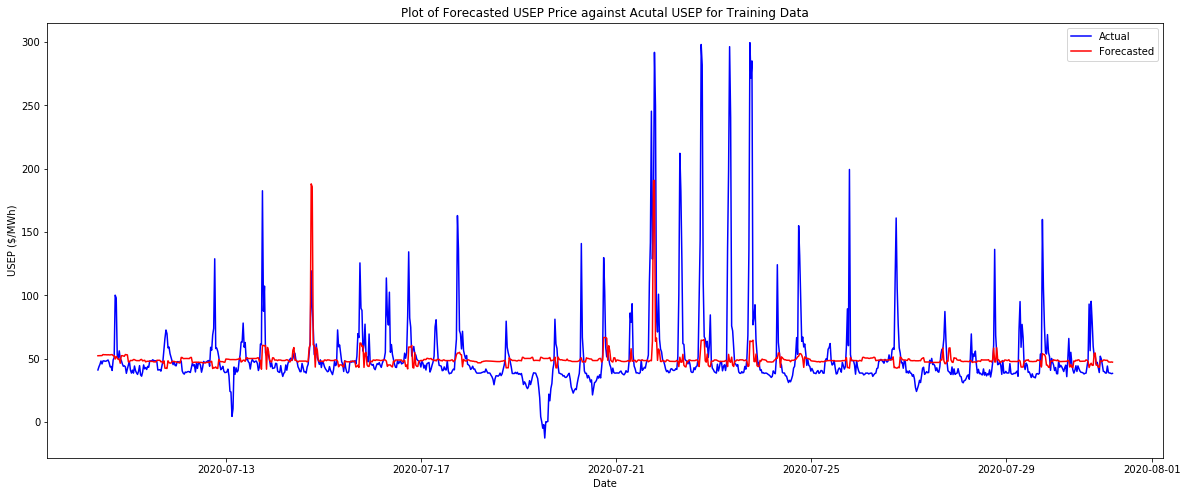

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(Time_ind[-1000:],y_train.values[-1000:],color='b',label='Actual')
plt.plot(Time_ind[-1000:],yhat[-1000:], color ='r', label='Forecasted')
plt.title('Plot of Forecasted USEP Price against Acutal USEP for Training Data')
plt.xlabel('Date')
plt.ylabel('USEP ($/MWh)')
plt.legend()

#### Visualize results for test set

In [0]:
datastore_paths = [(datastore, DataStore_TestPath)]
TestDF = Dataset.Tabular.from_delimited_files(path=datastore_paths)
df_test = TestDF.to_pandas_dataframe()

y_test = df_test[['RRP']]
Time_ind = df_test[['SETTLEMENTDATE']]
X_test = df_test.drop(['RRP','SETTLEMENTDATE','REGION','PERIODTYPE'], axis=1)

yhat =  best_model.predict(X_test)

In [0]:
# use automl metrics module
scores = scoring.score_regression(
    y_test=y_test,
    y_pred=yhat,
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))

[Test data scores]

root_mean_squared_error: 44.347
normalized_root_mean_squared_error: 0.023
normalized_root_mean_squared_log_error: nan
r2_score: -0.066
root_mean_squared_log_error: nan
explained_variance: -0.061
median_absolute_error: 11.093
mean_absolute_error: 16.695
mean_absolute_percentage_error: 62.730
normalized_mean_absolute_error: 0.009
spearman_correlation: -0.063
normalized_median_absolute_error: 0.006

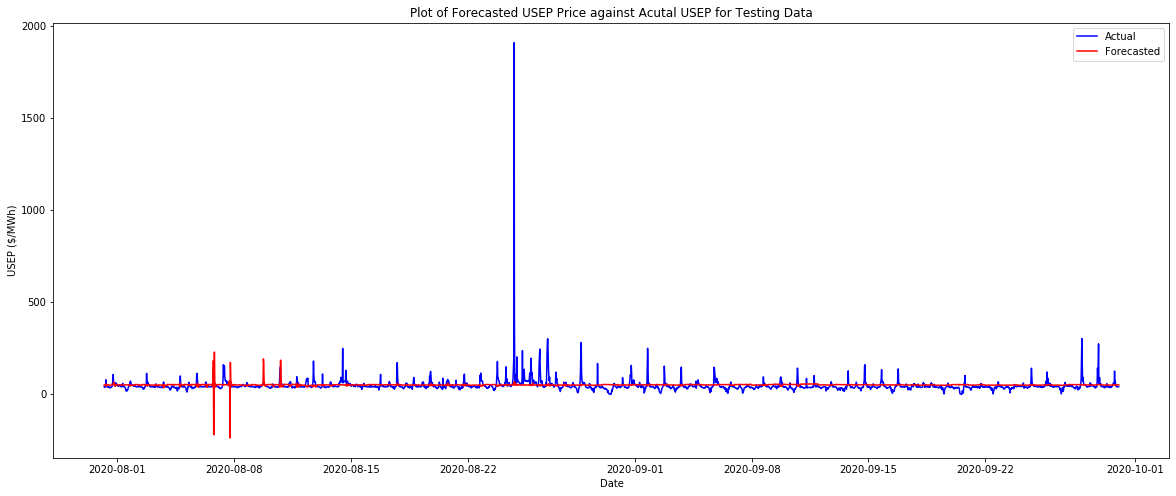

In [0]:
fig = plt.figure(figsize=(20,8))
plt.plot(Time_ind,y_test.values,color='b',label='Actual')
plt.plot(Time_ind,yhat, color ='r', label='Forecasted')
plt.title('Plot of Forecasted USEP Price against Acutal USEP for Testing Data')
plt.xlabel('Date')
plt.ylabel('USEP ($/MWh)')
plt.legend()

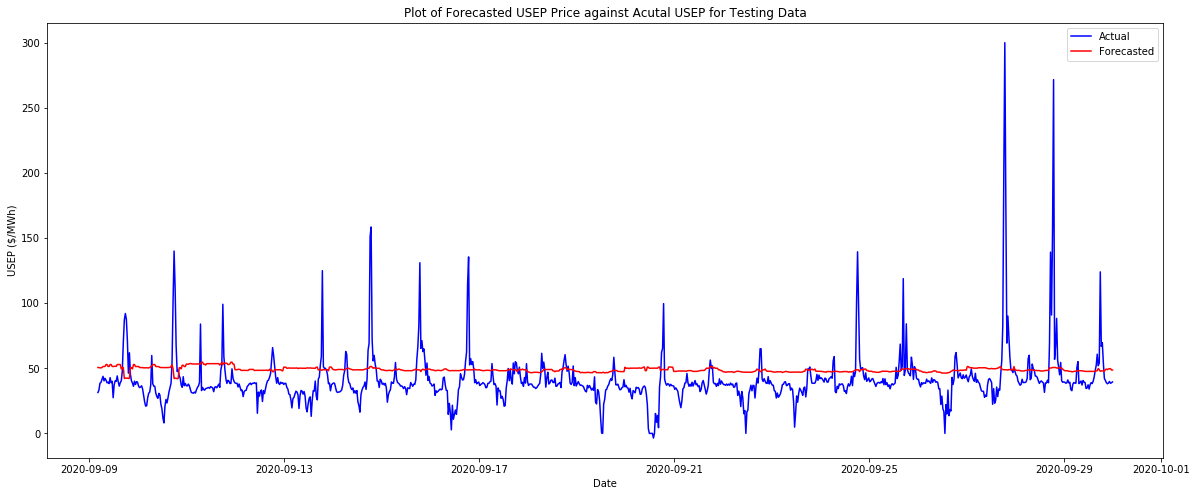

In [0]:
### Zoom in to look at the detailed forecasts
fig = plt.figure(figsize=(20,8))
plt.plot(Time_ind[-1000:],y_test.values[-1000:],color='b',label='Actual')
plt.plot(Time_ind[-1000:],yhat[-1000:], color ='r', label='Forecasted')
plt.title('Plot of Forecasted USEP Price against Acutal USEP for Testing Data')
plt.xlabel('Date')
plt.ylabel('USEP ($/MWh)')
plt.legend()